In [1]:
import sys

import numpy as np

import torch

from tqdm import tqdm

sys.path.insert(0, "./../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

# Evaluation on full 3DPW test set

### based on https://github.com/hongsukchoi/TCMR_RELEASE/blob/master/evaluate.py

In [3]:
device = "cuda:2"
torch.set_grad_enabled(False)

from collections import defaultdict

from src.losses.pose_eval import AccelerationError, MPJPE, PAMPJPE
from src.models.tcmr import get_tcmr

from src.utils.tcmr_utils import get_sequence, split_into_chunks

In [4]:
seqlen = 16
tcmr_model = get_tcmr().to(device)

### prepare 3dpw test set
from src.datasets.threedpw import ThreeDPW

dataset = ThreeDPW(set="test", seqlen=seqlen, debug=True)

### prepare dataset dict (features presaved)
dataset_data = dataset.db
vid_name_list = dataset_data["vid_name"]
unique_names = np.unique(vid_name_list)
data_keyed = {}

# make dictionary with video seqeunce names
for u_n in unique_names:
    indexes = vid_name_list == u_n
    if "valid" in dataset_data:
        valids = dataset_data["valid"][indexes].astype(bool)
    else:
        valids = np.ones(dataset_data["features"][indexes].shape[0]).astype(bool)
    data_keyed[u_n] = {
        "features": dataset_data["features"][indexes][valids],
        "joints3D": dataset_data["joints3D"][indexes][valids],
        "vid_name": dataset_data["vid_name"][indexes][valids],
        "imgname": dataset_data["img_name"][indexes][valids],
        "bbox": dataset_data["bbox"][indexes][valids],
    }

    data_keyed[u_n]["pose"] = dataset_data["pose"][indexes][valids]
    data_keyed[u_n]["shape"] = dataset_data["shape"][indexes][valids]
dataset_data = data_keyed


### map joints to H36M format (14 joints)
j_regr = "./../data/smpl_data/J_regressor_h36m.npy"
J_regressor = torch.from_numpy(np.load(j_regr)).float()

=> loaded pretrained regressor model from '/cvlabdata2/home/davydov/videoHMR_SSL/dump_from_tcmr/spin_model_checkpoint.pth.tar'
==> Loaded pretrained model from /cvlabdata2/home/davydov/videoHMR_SSL/dump_from_tcmr/tcmr_table4_3dpw_test.pth.tar...
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 2144


In [5]:
full_res = defaultdict(list)
m2mm = 1000
tcmr_model.eval()

tot_num_pose = 0
pbar = tqdm(dataset_data.keys())
for seq_name in pbar:
    curr_feats = dataset_data[seq_name]["features"]
    curr_feat = torch.tensor(curr_feats).to(device)
    vid_names = dataset_data[seq_name]["vid_name"]

    chunk_idxes = split_into_chunks(vid_names, seqlen=seqlen, stride=1, is_train=False, match_vibe=False)
    if chunk_idxes == []:
        continue

    pred_j3ds = []
    for curr_idx in range(0, len(chunk_idxes), 8):
        input_feat = []
        if (curr_idx + 8) < len(chunk_idxes):
            for ii in range(8):
                seq_select = get_sequence(chunk_idxes[curr_idx + ii][0], chunk_idxes[curr_idx + ii][1], seqlen=seqlen)
                input_feat.append(curr_feat[None, seq_select, :])
        else:
            for ii in range(curr_idx, len(chunk_idxes)):
                seq_select = get_sequence(chunk_idxes[ii][0], chunk_idxes[ii][1], seqlen=seqlen)
                input_feat.append(curr_feat[None, seq_select, :])

        input_feat = torch.cat(input_feat, dim=0)
        preds = tcmr_model(input_feat, J_regressor=J_regressor, is_train=False)[0][-1]

        n_kp = preds["kp_3d"].shape[-2]
        pred_j3d = preds["kp_3d"].view(-1, n_kp, 3).cpu().numpy()
        pred_j3ds.append(pred_j3d)

    pred_j3ds = np.vstack(pred_j3ds)

    target_j3ds = dataset_data[seq_name]["joints3D"]
    target_j3ds = target_j3ds[: len(pred_j3ds)]

    valid_map = np.arange(len(target_j3ds))

    pred_j3ds = torch.from_numpy(pred_j3ds).float()
    target_j3ds = torch.from_numpy(target_j3ds).float()

    num_eval_pose = len(valid_map)
    print(f"Evaluating on {num_eval_pose} data (number of poses) in {seq_name}...")
    tot_num_pose += num_eval_pose

    # per-frame accuracy
    mpjpe = MPJPE()(pred_j3ds, target_j3ds)[valid_map] * m2mm
    mpjpe_pa = PAMPJPE()(pred_j3ds, target_j3ds)[valid_map] * m2mm
    # acceleration error
    accel_err = np.zeros((pred_j3ds.shape[0],))
    accel_err[1:-1] = AccelerationError()(pred_j3ds, target_j3ds) * m2mm

    # exclude 0 from accel error calculation
    if valid_map[0] == 0:
        valid_map = valid_map[1:]
    if valid_map[-1] == len(accel_err) - 1:
        valid_map = valid_map[:-1]
    accel_err = accel_err[valid_map]

    full_res["mpjpe"].append(mpjpe)
    full_res["mpjpe_pa"].append(mpjpe_pa)
    full_res["accel_err"].append(accel_err)

print(f"Evaluated total {tot_num_pose} poses, seqlen {seqlen}")
full_res.pop(0, None)
full_res = {k: np.mean(np.concatenate(v)) for k, v in full_res.items()}
print(full_res)

  3%|███▊                                                                                                                                          | 1/37 [00:02<01:17,  2.14s/it]

Evaluating on 897 data (number of poses) in downtown_arguing_00_0...


  5%|███████▋                                                                                                                                      | 2/37 [00:04<01:11,  2.04s/it]

Evaluating on 895 data (number of poses) in downtown_arguing_00_1...


  8%|███████████▌                                                                                                                                  | 3/37 [00:06<01:18,  2.32s/it]

Evaluating on 1240 data (number of poses) in downtown_bar_00_0...


 11%|███████████████▎                                                                                                                              | 4/37 [00:08<01:04,  1.94s/it]

Evaluating on 578 data (number of poses) in downtown_bar_00_1...


 14%|███████████████████▏                                                                                                                          | 5/37 [00:10<01:04,  2.01s/it]

Evaluating on 1024 data (number of poses) in downtown_bus_00_0...


 16%|███████████████████████                                                                                                                       | 6/37 [00:13<01:14,  2.39s/it]

Evaluating on 1450 data (number of poses) in downtown_bus_00_1...


 19%|██████████████████████████▊                                                                                                                   | 7/37 [00:15<01:08,  2.30s/it]

Evaluating on 933 data (number of poses) in downtown_cafe_00_0...


 22%|██████████████████████████████▋                                                                                                               | 8/37 [00:17<01:07,  2.31s/it]

Evaluating on 1137 data (number of poses) in downtown_cafe_00_1...


 24%|██████████████████████████████████▌                                                                                                           | 9/37 [00:19<00:58,  2.10s/it]

Evaluating on 800 data (number of poses) in downtown_car_00_0...


 27%|██████████████████████████████████████                                                                                                       | 10/37 [00:20<00:51,  1.92s/it]

Evaluating on 722 data (number of poses) in downtown_car_00_1...


 30%|█████████████████████████████████████████▉                                                                                                   | 11/37 [00:22<00:44,  1.69s/it]

Evaluating on 528 data (number of poses) in downtown_crossStreets_00_0...


 32%|█████████████████████████████████████████████▋                                                                                               | 12/37 [00:23<00:38,  1.52s/it]

Evaluating on 505 data (number of poses) in downtown_crossStreets_00_1...


 35%|█████████████████████████████████████████████████▌                                                                                           | 13/37 [00:24<00:35,  1.49s/it]

Evaluating on 628 data (number of poses) in downtown_downstairs_00_0...


 38%|█████████████████████████████████████████████████████▎                                                                                       | 14/37 [00:27<00:46,  2.01s/it]

Evaluating on 1358 data (number of poses) in downtown_enterShop_00_0...


 41%|█████████████████████████████████████████████████████████▏                                                                                   | 15/37 [00:30<00:44,  2.04s/it]

Evaluating on 980 data (number of poses) in downtown_rampAndStairs_00_0...


 43%|████████████████████████████████████████████████████████████▉                                                                                | 16/37 [00:32<00:43,  2.07s/it]

Evaluating on 974 data (number of poses) in downtown_rampAndStairs_00_1...


 46%|████████████████████████████████████████████████████████████████▊                                                                            | 17/37 [00:33<00:37,  1.87s/it]

Evaluating on 644 data (number of poses) in downtown_runForBus_00_0...


 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 18/37 [00:35<00:33,  1.74s/it]

Evaluating on 655 data (number of poses) in downtown_runForBus_00_1...


 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 19/37 [00:36<00:30,  1.71s/it]

Evaluating on 738 data (number of poses) in downtown_runForBus_01_0...


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 20/37 [00:38<00:28,  1.68s/it]

Evaluating on 682 data (number of poses) in downtown_runForBus_01_1...


 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 21/37 [00:41<00:32,  2.05s/it]

Evaluating on 1301 data (number of poses) in downtown_sitOnStairs_00_0...


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 22/37 [00:44<00:34,  2.32s/it]

Evaluating on 1329 data (number of poses) in downtown_sitOnStairs_00_1...


 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 23/37 [00:46<00:33,  2.42s/it]

Evaluating on 1190 data (number of poses) in downtown_stairs_00_0...


 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 24/37 [00:48<00:29,  2.25s/it]

Evaluating on 825 data (number of poses) in downtown_upstairs_00_0...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 25/37 [00:51<00:28,  2.36s/it]

Evaluating on 1179 data (number of poses) in downtown_walkBridge_01_0...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 26/37 [00:52<00:21,  1.92s/it]

Evaluating on 385 data (number of poses) in downtown_walkUphill_00_0...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 27/37 [00:55<00:22,  2.23s/it]

Evaluating on 1325 data (number of poses) in downtown_walking_00_0...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 28/37 [00:57<00:21,  2.39s/it]

Evaluating on 1256 data (number of poses) in downtown_walking_00_1...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 29/37 [00:59<00:16,  2.05s/it]

Evaluating on 568 data (number of poses) in downtown_warmWelcome_00_0...


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 30/37 [01:00<00:12,  1.81s/it]

Evaluating on 552 data (number of poses) in downtown_warmWelcome_00_1...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 31/37 [01:02<00:11,  1.97s/it]

Evaluating on 1043 data (number of poses) in downtown_weeklyMarket_00_0...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 32/37 [01:06<00:13,  2.62s/it]

Evaluating on 1806 data (number of poses) in downtown_windowShopping_00_0...


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 33/37 [01:08<00:09,  2.33s/it]

Evaluating on 748 data (number of poses) in flat_guitar_01_0...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 34/37 [01:11<00:07,  2.49s/it]

Evaluating on 1273 data (number of poses) in flat_packBags_00_0...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 35/37 [01:12<00:04,  2.23s/it]

Evaluating on 724 data (number of poses) in office_phoneCall_00_0...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 36/37 [01:14<00:02,  2.06s/it]

Evaluating on 764 data (number of poses) in office_phoneCall_00_1...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [01:16<00:00,  2.07s/it]

Evaluating on 925 data (number of poses) in outdoors_fencing_01_0...
Evaluated total 34561 poses, seqlen 16
{'mpjpe': 86.45539, 'mpjpe_pa': 52.66955, 'accel_err': 6.7718792010192566}


In [7]:
full_res

{'mpjpe': 86.45539, 'mpjpe_pa': 52.66955, 'accel_err': 6.7718792010192566}

### Table 4 

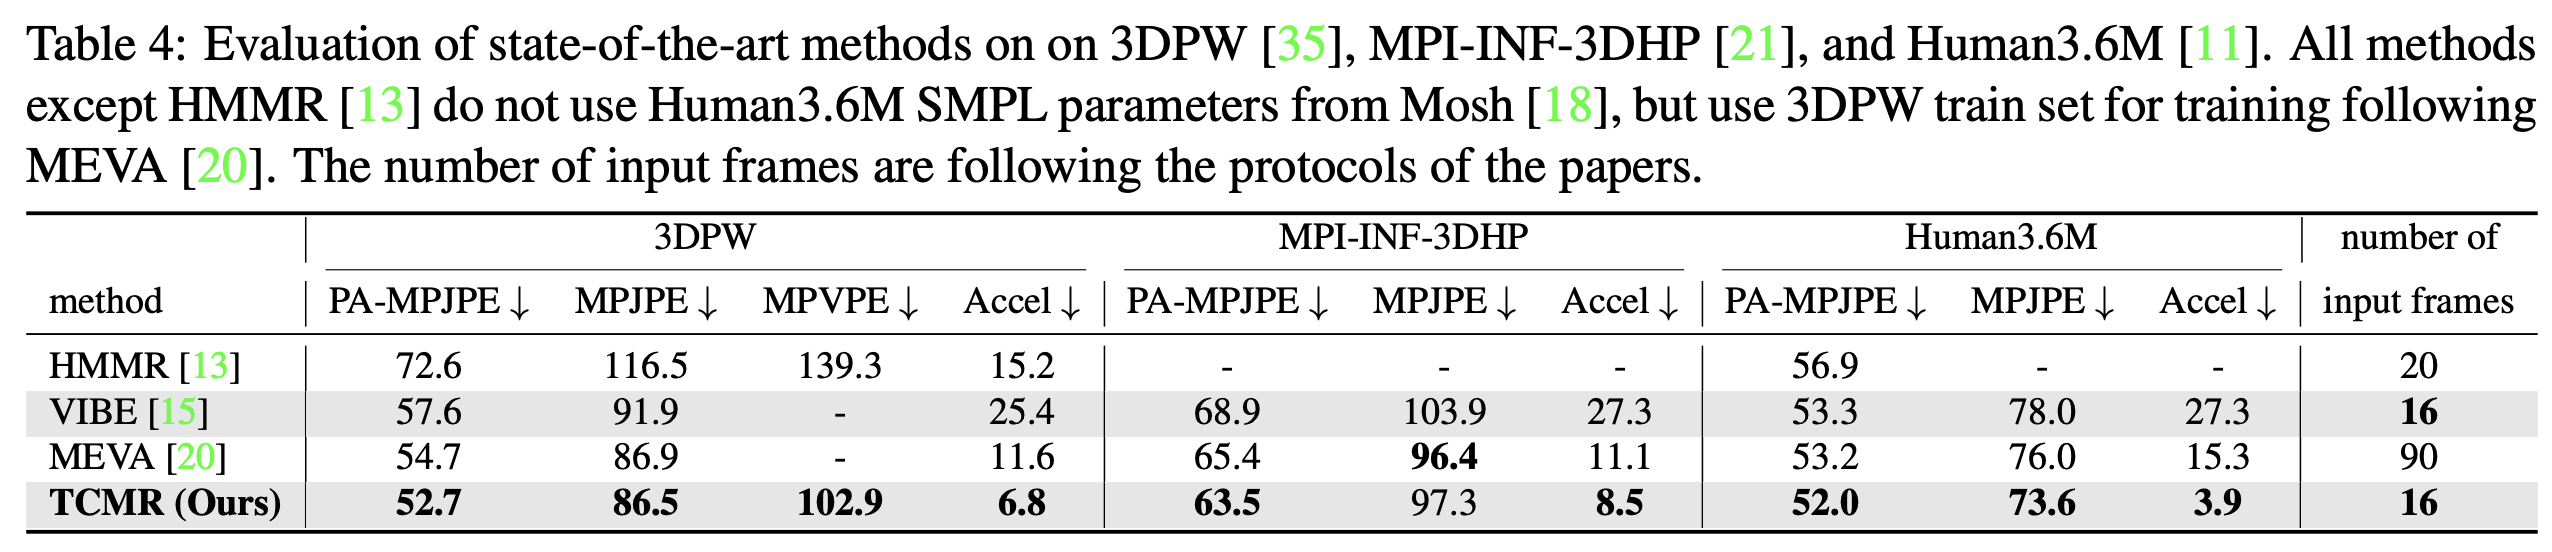

mpjpe: 86.5, mpjpe_pa: 52.7, accel_err: 6.8